In [39]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from dataImportHelper import parse_image_MSR, preprocess_MSR
from model import create_low_level_stage

In [46]:
CKPT_PATH = 'training_DD_1/cp.ckpt'
LOG_PATH = 'DD_training.log'
PANASONIC_DATA_PATH = 'MSR-Demosaicing/Dataset_LINEAR_with_noise/bayer_panasonic'
DATAX_PATH = os.path.join(os.getcwd(),PANASONIC_DATA_PATH,'input_dem') 
DATAY_PATH = os.path.join(os.getcwd(),PANASONIC_DATA_PATH,'groundtruth') 

In [9]:
res = pd.read_csv(LOG_PATH)

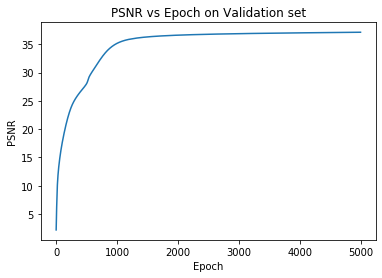

In [23]:
# Plot PSNR metric on validation set
plt.plot(res['epoch'],res['PSNR_metric'])
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR vs Epoch on Validation set');

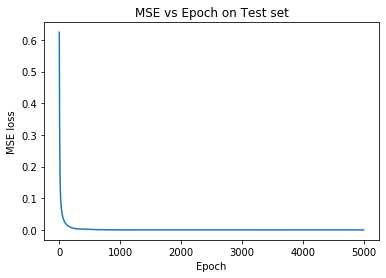

In [24]:
# Plot loss
plt.plot(res['epoch'],res['loss'])
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.title('MSE vs Epoch on Test set');

In [42]:
H = 132
W = 220
Nll = 20 #Number of low level blocks
ll_model = create_low_level_stage(H,W,Nll)

In [67]:
ds_dict = {'test':[]}
for i in ['test']:
    with open(os.path.join(PANASONIC_DATA_PATH,i+'.txt'),'r') as f:
        ds_dict[i] = f.readlines()
        ds_dict[i] = [int(x) for x in ds_dict[i]]
        #print(ds_dict[i])
        

In [68]:
X_test_paths = tf.constant([os.path.join(DATAX_PATH,str(xname)+'.png') for xname in ds_dict['test']]) 
Y_test_paths = tf.constant([os.path.join(DATAY_PATH,str(yname)+'.png') for yname in ds_dict['test']])

list_ds_test_X = tf.data.Dataset.list_files(X_test_paths, seed=42) # seed for random but consistent shuffling #TODO: vs ds.shuffle(buffer)  ??
list_ds_test_Y = tf.data.Dataset.list_files(Y_test_paths, seed=42)

testX = list_ds_test_X.map(parse_image_MSR)
testY = list_ds_test_Y.map(parse_image_MSR)

#ds_test = tf.data.Dataset.zip((testX,testY)).batch(BATCH_SIZE)

In [83]:
#Note: if we want to test images other than the panasonic dataset, we probably have to reshape 
# the images to the dimensions the network expects. It is not necessary but an easy work around

# Image paths
img_path = os.path.join(DATAX_PATH,'1.png') # test image path
gt_img_path = os.path.join(DATAY_PATH,'1.png') # ground truth image path
#Read image raw bytes
image = tf.io.read_file(img_path) 
gt_image = tf.io.read_file(gt_img_path)
##Decode image as png
image = tf.image.decode_png(image) 
gt_image = tf.image.decode_png(gt_image)
# Convert datatype
image = tf.image.convert_image_dtype(image, tf.float32)
gt_image = tf.image.convert_image_dtype(gt_image, tf.float32)
# Need to add batch dimension before passing through network
# Note if you want to test a bunch of images together, look at .batch function and apply it to testX
# If you do that then you probably don't need the below function
image = tf.expand_dims(image, 0) 
gt_image = tf.expand_dims(gt_image, 0)

In [73]:
# Load learned weights
ll_model.load_weights(CKPT_PATH)

In [79]:
y = ll_model(image) # denoised democaiced image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


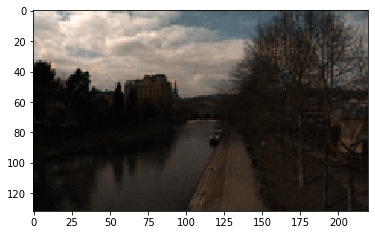

In [84]:
# Network result
plt.imshow(y[0,:,:,:])

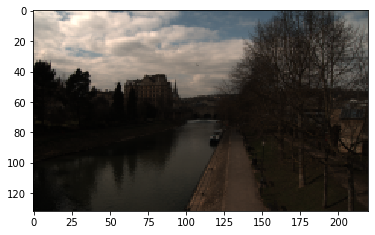

In [86]:
# Groundtruth from panasonic
plt.imshow(gt_image[0,:,:,:])

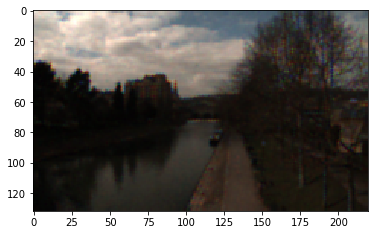

In [88]:
# Original "raw" image, just demosaiced with bilinear
plt.imshow(image[0,:,:,:])